# Bagging & Ensemble Methods — Theory, Implementation, and Visualization

Author: *SeyedMohammadreza Mousavi*  
Last updated: 2025-10-14

---

This notebook is a **self‑contained tutorial** on bootstrap aggregating (*bagging*) and closely related ensemble methods such as **Random Forests**. It covers:

1. Intuition and math foundations
2. Bias–variance perspective and why bagging helps
3. Out‑of‑bag (OOB) estimation
4. Implementations with scikit‑learn (classification & regression)
5. Visualizations: decision boundaries, OOB error vs. trees, feature importance
6. Practical tips & hyperparameter guidelines

---

## 1. What is Bagging?

Bagging (Bootstrap AGGregatING) is an ensemble technique that reduces variance by training **$B$** base learners on **bootstrap samples** of the training set and averaging (regression) or majority voting (classification) their predictions.

Given a training set $\mathcal{D} = \{(\mathbf{x}_i, y_i)\}_{i=1}^n$, a **bootstrap sample** $\mathcal{D}^{(b)}$ is formed by sampling $n$ points **with replacement** from $\mathcal{D}$. A base learner $h^{(b)}$ (e.g., a decision tree) is trained on $\mathcal{D}^{(b)}$.

For **regression**, the bagged predictor is

$$\hat{f}_{\text{bag}}(\mathbf{x}) = \frac{1}{B} \sum_{b=1}^{B} h^{(b)}(\mathbf{x}).$$

For **binary classification**, the bagged classifier predicts by **majority vote**:

$$\hat{y}_{\text{bag}}(\mathbf{x}) = \operatorname*{mode}\big( h^{(1)}(\mathbf{x}),\ldots,h^{(B)}(\mathbf{x}) \big).$$

More generally, if the base learner outputs class probabilities $\hat{p}^{(b)}(y\mid\mathbf{x})$, we can average probabilities and select $\arg\max_y$.

## 2. Why Does Bagging Work? Bias–Variance View

Let $\hat{f}(\mathbf{x})$ be an estimator for a regression target with noise variance $\sigma^2$. The expected squared error decomposes as

$$\mathbb{E}\big[(Y-\hat{f}(\mathbf{x}))^2\big] = \underbrace{\operatorname{Bias}[\hat{f}(\mathbf{x})]^2}_{\text{systematic error}} + \underbrace{\operatorname{Var}[\hat{f}(\mathbf{x})]}_{\text{estimator variance}} + \sigma^2.$$

If we average **independent** estimators $\{\hat{f}^{(b)}\}_{b=1}^B$ with common variance $\tau^2$ and pairwise correlation $\rho$ (assumed constant),

$$\operatorname{Var}\!\left[ \frac{1}{B} \sum_{b=1}^B \hat{f}^{(b)} \right] = \frac{1}{B^2}\left( B\tau^2 + B(B-1)\rho\,\tau^2 \right) = \tau^2\left( \rho + \frac{1-\rho}{B} \right).$$

Thus, as $B\to\infty$, the variance approaches $\rho\,\tau^2$. **Bagging helps most when base learners are high‑variance and weakly correlated.** Decision trees are a classic example.


## 3. Bootstrap & Out‑of‑Bag (OOB) Estimation

In each bootstrap sample, the probability that a specific training point is **not** selected is $(1-\tfrac{1}{n})^n \approx e^{-1} \approx 0.368$. So about **36.8%** of the data is typically left out (called **out‑of‑bag**). We can use these OOB points to estimate generalization error **without a separate validation set**.

For observation $i$, define $\mathcal{B}_i=\{b: (\mathbf{x}_i, y_i)\notin \mathcal{D}^{(b)}\}$. The OOB prediction is

$$\hat{f}_{\text{OOB}}(\mathbf{x}_i) = \frac{1}{|\mathcal{B}_i|} \sum_{b\in\mathcal{B}_i} h^{(b)}(\mathbf{x}_i).$$

Aggregating over all $i$ yields the OOB error estimate. In scikit‑learn, set `oob_score=True` in `BaggingClassifier`/`BaggingRegressor` or `RandomForest*`.

## 4. Random Forests (Brief)

Random Forests add **feature subsampling** to further reduce correlation between trees. At each split, a random subset of features of size $m_{\text{try}}$ is considered. Typical defaults:

- Classification: $m_{\text{try}} = \lfloor \sqrt{d} \rfloor$
- Regression: $m_{\text{try}} = \lfloor d/3 \rfloor$

This increases diversity among trees, often improving performance over plain bagging.

## 5. Theoretical Glimpse: Majority Vote Error (Binary, i.i.d., Symmetric)

Suppose each base classifier has error $\varepsilon<\tfrac{1}{2}$ and are i.i.d. Let $S\sim\operatorname{Binomial}(B,\varepsilon)$ be the number of errors among $B$ classifiers. Majority vote errs when $S>\tfrac{B}{2}$. Then

$$\Pr\{\text{maj. vote wrong}\} = \sum_{k=\lceil (B+1)/2\rceil}^{B} \binom{B}{k}\,\varepsilon^k (1-\varepsilon)^{B-k},$$

which **decreases exponentially** in $B$ when $\varepsilon<\tfrac{1}{2}$ (by Chernoff bounds). In practice, base learners are correlated, so the benefit plateaus, matching the variance formula with correlation $\rho$ above.

## 6. Implementation — Classification (Moons & Breast Cancer)

We compare a single Decision Tree, Bagging, and Random Forest. We'll visualize decision boundaries on a 2‑D dataset and evaluate metrics on a real dataset.


In [1]:
# Setup
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, load_breast_cancer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
np.random.seed(42)
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.grid'] = True
print('Libraries ready.')

Libraries ready.


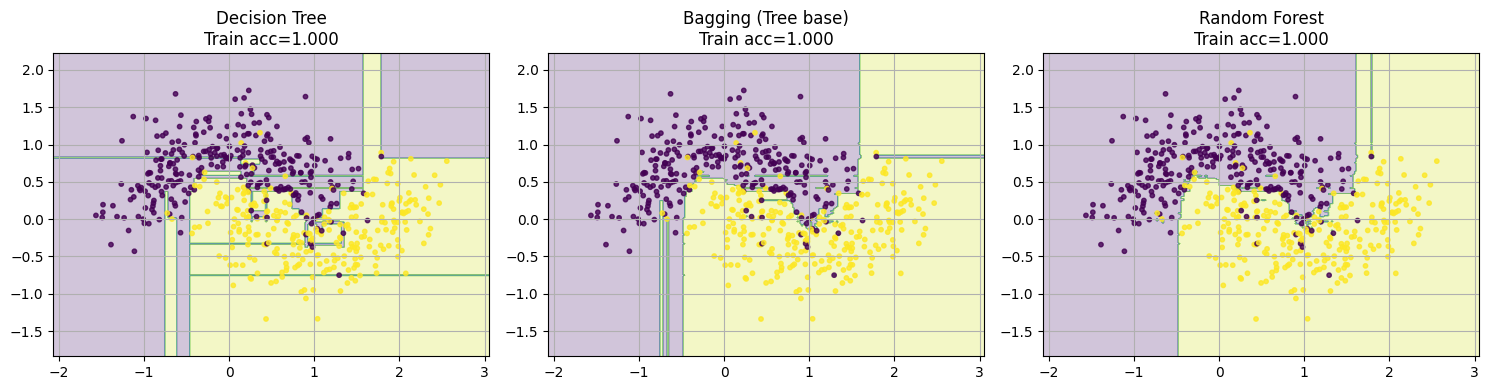

In [3]:
X, y = make_moons(n_samples=800, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=None),
    'Bagging (Tree base)': BaggingClassifier(
        estimator=DecisionTreeClassifier(random_state=42),  # ← changed here
        n_estimators=200, bootstrap=True, oob_score=True, random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, oob_score=True, n_jobs=-1, random_state=42
    )
}

def plot_decision_boundary(clf, X, y, ax, title=''):
    # mesh
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.25)
    ax.scatter(X[:,0], X[:,1], c=y, s=10, alpha=0.8)
    ax.set_title(title)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, (name, clf) in zip(axes, models.items()):
    clf.fit(X_train, y_train)
    plot_decision_boundary(clf, X_train, y_train, ax,
                           title=f"{name}\nTrain acc={clf.score(X_train, y_train):.3f}")
plt.tight_layout()
plt.show()

In [4]:
# Test accuracy & OOB scores if available
for name, clf in models.items():
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    oob = getattr(clf, 'oob_score_', None)
    print(f"{name:18s} | Test acc: {acc:.3f} | OOB: {oob if oob is not None else '—'}")

Decision Tree      | Test acc: 0.879 | OOB: —
Bagging (Tree base) | Test acc: 0.912 | OOB: 0.9142857142857143
Random Forest      | Test acc: 0.933 | OOB: 0.9089285714285714


Random Forest breast cancer
Test accuracy: 0.958041958041958
OOB score: 0.9624413145539906


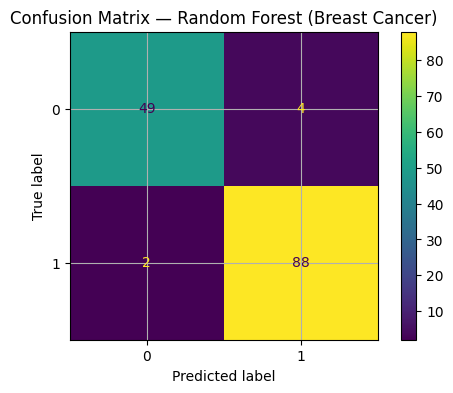

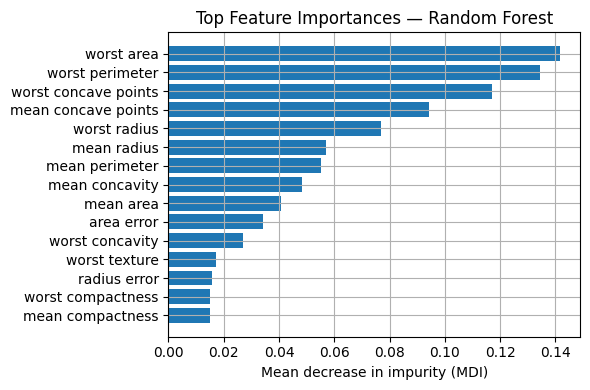

In [5]:
# Real dataset: Breast Cancer Wisconsin
data = load_breast_cancer()
X_bc, y_bc = data.data, data.target
Xtr, Xte, ytr, yte = train_test_split(X_bc, y_bc, test_size=0.25, random_state=42, stratify=y_bc)

rf = RandomForestClassifier(n_estimators=400, max_depth=None, oob_score=True, n_jobs=-1, random_state=42)
rf.fit(Xtr, ytr)
yp = rf.predict(Xte)
print('Random Forest breast cancer')
print('Test accuracy:', accuracy_score(yte, yp))
print('OOB score:', rf.oob_score_)
disp = ConfusionMatrixDisplay.from_estimator(rf, Xte, yte)
plt.title('Confusion Matrix — Random Forest (Breast Cancer)')
plt.show()

# Feature importance plot
importances = rf.feature_importances_
idx = np.argsort(importances)[-15:]
plt.barh(range(len(idx)), importances[idx])
plt.yticks(range(len(idx)), [data.feature_names[i] for i in idx])
plt.xlabel('Mean decrease in impurity (MDI)')
plt.title('Top Feature Importances — Random Forest')
plt.tight_layout()
plt.show()

## 7. Implementation — Regression (Bagging vs. RF vs. Single Tree)

We'll use the **Diabetes** regression dataset and compare models using $R^2$ and RMSE. We'll also illustrate how performance evolves with the number of estimators and show OOB curves.

In [11]:
from sklearn.datasets import load_diabetes
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from math import sqrt

X, y = load_diabetes(return_X_y=True)
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.25, random_state=42)

tree = DecisionTreeRegressor(random_state=42)
bag = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=42),
    n_estimators=200, oob_score=True, bootstrap=True, random_state=42
)
rf = RandomForestRegressor(n_estimators=400, oob_score=True, n_jobs=-1, random_state=42)

for name, model in [('Tree', tree), ('Bagging', bag), ('Random Forest', rf)]:
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    rmse = sqrt(mean_squared_error(yte, pred))  # <- fixed
    r2 = r2_score(yte, pred)
    oob = getattr(model, 'oob_score_', None)
    print(f"{name:14s} | RMSE={rmse:.3f} | R2={r2:.3f} | OOB={oob if oob is not None else '—'}")

Tree           | RMSE=77.082 | R2=-0.075 | OOB=—
Bagging        | RMSE=54.263 | R2=0.468 | OOB=0.4314406055830341
Random Forest  | RMSE=54.336 | R2=0.466 | OOB=0.43429027488003635


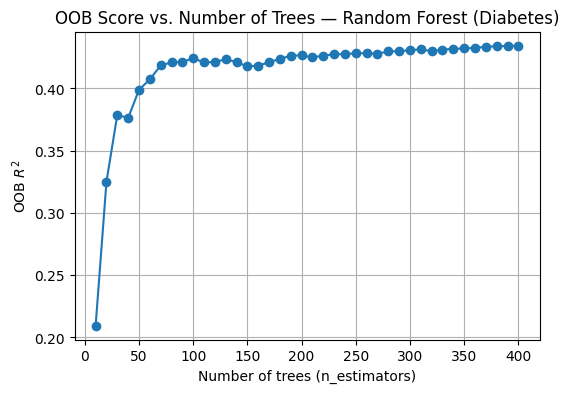

In [12]:
# OOB score vs. number of estimators (Random Forest)
oobs, ns = [], list(range(10, 401, 10))
for n in ns:
    rf_tmp = RandomForestRegressor(n_estimators=n, oob_score=True, n_jobs=-1, random_state=42)
    rf_tmp.fit(Xtr, ytr)
    oobs.append(rf_tmp.oob_score_)

plt.plot(ns, oobs, marker='o')
plt.xlabel('Number of trees (n_estimators)')
plt.ylabel('OOB $R^2$')
plt.title('OOB Score vs. Number of Trees — Random Forest (Diabetes)')
plt.show()

## 8. Practical Tips

- **When to use bagging?** When base learners are **high variance** (e.g., deep decision trees). For stable/low‑variance models (e.g., linear regression), bagging yields little benefit.
- **OOB vs. CV:** OOB gives a fast internal estimate; you can still use cross‑validation for final model selection.
- **n_estimators:** Increase until OOB/test performance plateaus. More trees rarely overfit; compute time/memory are the main limits.
- **Random Forest:** Strong default baseline for tabular data; tune `max_features`, tree depth (`max_depth`), and `min_samples_leaf`.
- **Class imbalance:** Use `class_weight='balanced'` or resampling strategies if needed.
- **Interpretability:** Prefer permutation importance or SHAP for more reliable attribution than raw MDI.


## 9. Appendix — Derivations and Helpful Identities

### 9.1 Variance of an Averaged Ensemble with Correlated Base Learners

Let $\hat{f}^{(b)}$ have $\operatorname{Var}[\hat{f}^{(b)}]=\tau^2$ and pairwise correlation $\rho$. Then

$$\operatorname{Var}\!\left[ \frac{1}{B} \sum_{b=1}^B \hat{f}^{(b)} \right] = \tau^2\left( \rho + \frac{1-\rho}{B} \right).$$

This identity explains why **decorrelation** (via feature subsampling in Random Forests) improves ensembles.

### 9.2 Probability of Being OOB

A point is OOB for a bootstrap sample with probability

$$\left(1-\frac{1}{n}\right)^n \xrightarrow[n\to\infty]{} e^{-1} \approx 0.368.$$

## 10. Reproducible Summary (Copy‑Paste Friendly)

We summarize the key equations using proper math formatting in single‑line blocks (good for notebooks):

$$\hat{f}_{\text{bag}}(\mathbf{x}) = \frac{1}{B} \sum_{b=1}^{B} h^{(b)}(\mathbf{x}).$$
$$\Pr\{\text{majority vote wrong}\} = \sum_{k=\lceil (B+1)/2\rceil}^{B} \binom{B}{k}\,\varepsilon^k (1-\varepsilon)^{B-k}.$$
$$\operatorname{Var}\!\left[ \tfrac{1}{B} \sum_{b=1}^{B} \hat{f}^{(b)} \right] = \tau^2\!\left( \rho + \frac{1-\rho}{B} \right).$$
$$\Pr\{\text{OOB}\} \approx e^{-1} \approx 0.368.$$